In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

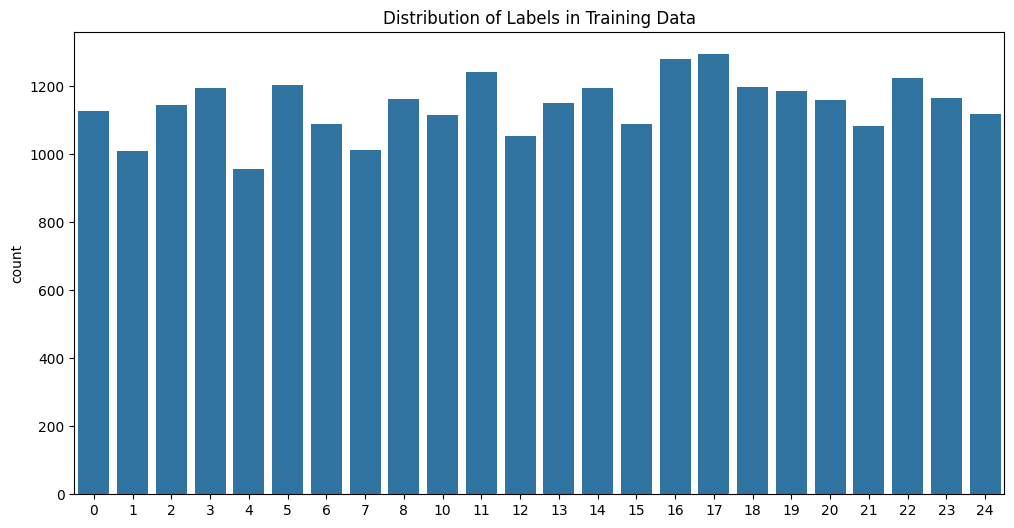

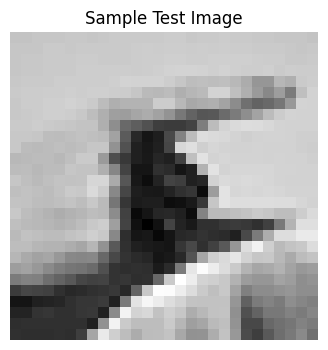

In [2]:
train_path = '/content/drive/MyDrive/Software Engineering Project/kaggle-mnist/sign_mnist_train/sign_mnist_train.csv'
test_path  = '/content/drive/MyDrive/Software Engineering Project/kaggle-mnist/sign_mnist_test/sign_mnist_test.csv'

# Load datasets
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Visualize training label distribution
labels = train_df['label'].values
plt.figure(figsize=(12, 6))
sns.countplot(x=labels)
plt.title("Distribution of Labels in Training Data")
plt.show()

# Process training data
train_labels = train_df['label'].values
train_df.drop('label', axis=1, inplace=True)
train_images = train_df.values

# Reshape each image (flattened 784 values) to 28x28
train_images = np.array([np.reshape(i, (28, 28)) for i in train_images])
# Flatten them again if needed for any intermediate steps (we reshape later for CNN)
train_images = np.array([i.flatten() for i in train_images])

# One-hot encode labels
lb = LabelBinarizer()
train_labels_encoded = lb.fit_transform(train_labels)

# Split training data (90% train, 10% validation)
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels_encoded,
                                                  test_size=0.1, random_state=101)

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_val   = x_val / 255.0

# Reshape images to (28, 28, 1) for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_val   = x_val.reshape(-1, 28, 28, 1)

# Process test data similarly
test_labels = test_df['label'].values
test_df.drop('label', axis=1, inplace=True)
test_images = test_df.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_images = test_images / 255.0
test_images = test_images.reshape(-1, 28, 28, 1)

# Optionally visualize a sample test image
plt.figure(figsize=(4,4))
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.title("Sample Test Image")
plt.axis('off')
plt.show()

In [3]:
# Tuned hyperparameters:
#   conv1_filters: 64
#   conv2_filters: 64
#   conv3_filters: 384
#   dense_units:   320
#   dropout_rate:  0.25
#   learning_rate: 0.001
#   num_classes:   24 (for sign language letters)
num_classes = 24

from tensorflow.keras import Input

# Input Layer
inputs = Input(shape=(28, 28, 1))

# First Convolutional Block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third Convolutional Block
x = Conv2D(filters=384, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

# Dense Feature Layer
feature_layer = Dense(units=320, activation='relu')(x)

# Dropout and Output
x = Dropout(rate=0.25)(feature_layer)
outputs = Dense(num_classes, activation='softmax')(x)

# Full CNN Model
cnn_model = Model(inputs=inputs, outputs=outputs)

# Compile
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [4]:
# Creating a CNN model that outputs the features from
# the penultimate layer (the Dense layer before dropout/output).
feature_extractor = Model(inputs=cnn_model.input,
                          outputs=cnn_model.layers[-3].output)  # -3 corresponds to the Dense layer

# Extract features for training and validation sets
train_features = feature_extractor.predict(x_train)
val_features   = feature_extractor.predict(x_val)
test_features  = feature_extractor.predict(test_images)

# Standardize the features for SVM training
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled   = scaler.transform(val_features)
test_features_scaled  = scaler.transform(test_features)

# Convert one-hot labels back to integer labels for the SVM
y_train_int = np.argmax(y_train, axis=1)
y_val_int   = np.argmax(y_val, axis=1)
test_labels_int = test_labels

773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [5]:
# Tuned SVM parameters:
#   kernel = 'rbf'
#   C = 1.0
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(train_features_scaled, y_train_int)

# Validate on the CNN validation features
y_val_pred = svm_model.predict(val_features_scaled)
val_accuracy = accuracy_score(y_val_int, y_val_pred)
print("Validation Accuracy using SVM on CNN Features: {:.2f}%".format(val_accuracy * 100))

# Evaluate on test set (if available)
y_test_pred = svm_model.predict(test_features_scaled)
test_accuracy = accuracy_score(test_labels_int, y_test_pred)
print("Test Accuracy using SVM on CNN Features: {:.2f}%".format(test_accuracy * 100))

Validation Accuracy using SVM on CNN Features: 99.60%
Test Accuracy using SVM on CNN Features: 41.05%


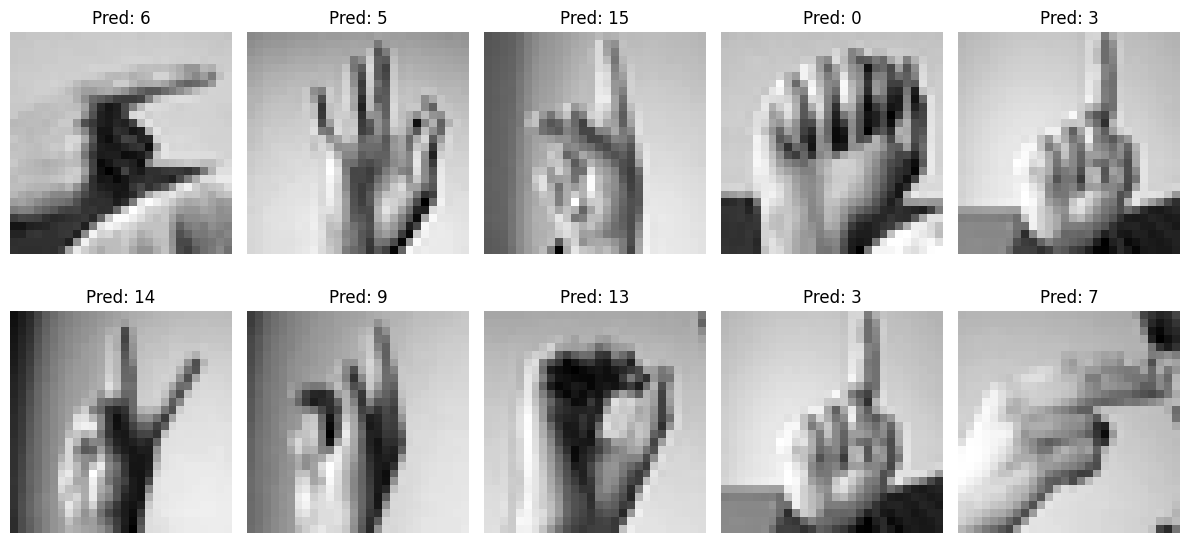

In [6]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_test_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()